In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from DesignMat import Polynomial
from Regressor import Bayesian

def create_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(*domain, sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

<b> Example </b>

Consider a simple linear model of the form $y(x, \mathbf{w}) = -0.3 + 0.5 x$. We demonstrate how $p(\mathbf{w} | \mathbf{t}, \mathbf{X})$ changes in learning

- Figure prior/posterior shows the initial belief of $\mathbf{w}$ and how it involves with knowing more data points
- Note that the likelihood function provides a soft constraint that the line must pass close to the data point, where close is determined by the noise precision $\beta$
- The orange lines in Figure data space are based on randomly generated $\mathbf{x}$ following current belief

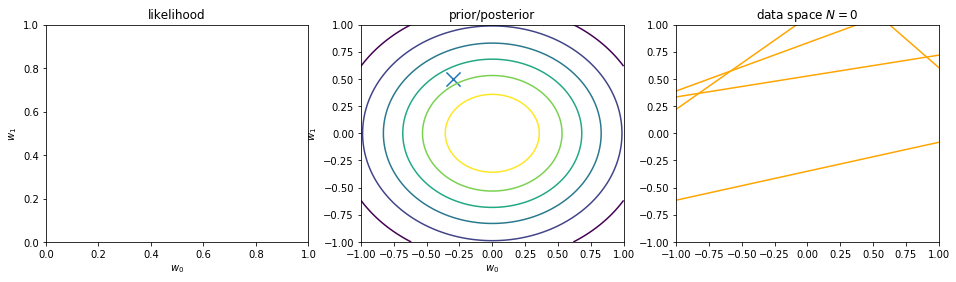

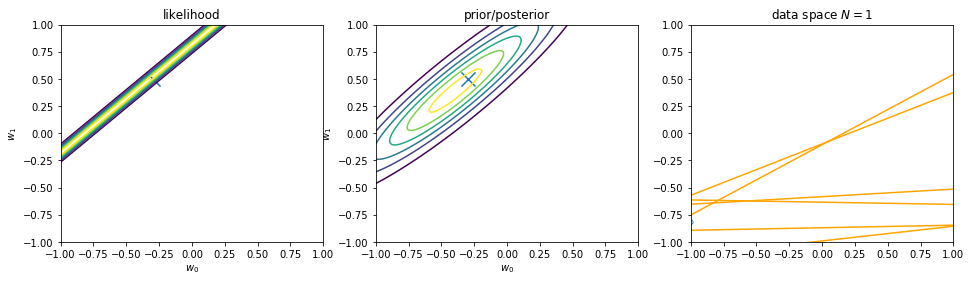

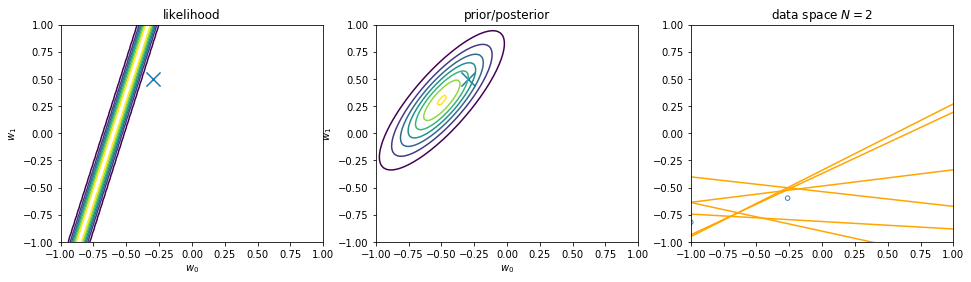

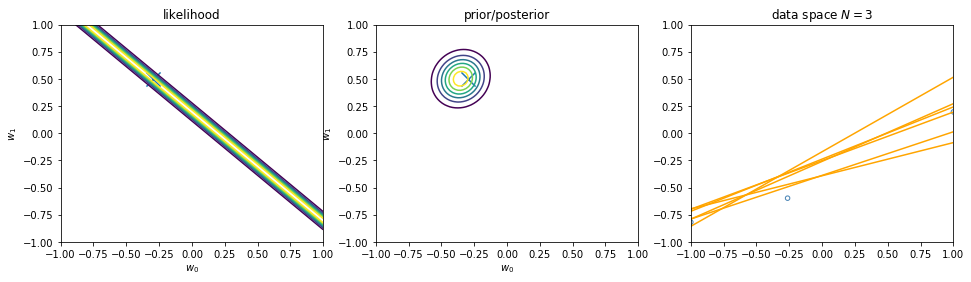

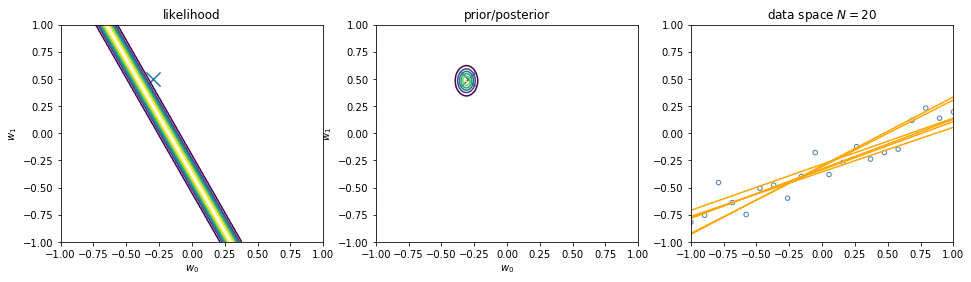

In [2]:
def linear(x):
    return -0.3 + 0.5 * x

w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

x_train, t_train = create_data(linear, 20, 0.1, [-1, 1])
x_test = np.linspace(-1, 1, 100)

phi_train = Polynomial(1).dm(x_train)
phi_test  = Polynomial(1).dm(x_test)

model = Bayesian(alpha=2., beta=25.)

for beg, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(phi_train[beg: end], t_train[beg: end])
    
    fig, axes = plt.subplots(1,3,figsize=(16, 4))
    if end > 0:
        axes[0].scatter(-0.3, 0.5, s=200, marker="x")
        # likelihood function is products of N normal dist. Use standardization.
        axes[0].contour(w0, w1, multivariate_normal.pdf((-t_train[end-1: end] + w @ phi_train[end-1: end].T)*model.beta))
    axes[0].set_xlabel("$w_0$")
    axes[0].set_ylabel("$w_1$")
    axes[0].set_title("likelihood")    
    
    axes[1].scatter(-0.3, 0.5, s=200, marker="x")
    axes[1].contour(w0, w1, multivariate_normal.pdf(w, mean=model.w_mean, cov=model.w_cov))
    axes[1].set_xlabel("$w_0$")
    axes[1].set_ylabel("$w_1$")
    axes[1].set_title("prior/posterior")
    
    axes[2].scatter(x_train[:end], t_train[:end], s=20, facecolor="none", edgecolor="steelblue", lw=1)
    # use posterior dist to generate w, and then w is used for prediction
    axes[2].plot(x_test, phi_test @ np.random.multivariate_normal(model.w_mean, model.w_cov, size=6).T, c="orange")
    axes[2].set_xlim(-1, 1)
    axes[2].set_ylim(-1, 1)
    axes[2].set_title(r"data space $N={}$".format(end))
    
    plt.show()